<a href="https://colab.research.google.com/github/Thamil2725/HOGFeatureExtractor/blob/main/HOGFeatureExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

## Connecting with the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Edge Detector

In [ ]:
def Robert_cross_edge_detector(image):

    Gx_kernel = np.array([[1, 0],
                          [0, -1]])
    Gy_kernel = np.array([[0, 1],
                          [-1, 0]])

    Gx = cv2.filter2D(image, -1, Gx_kernel)
    Gy = cv2.filter2D(image, -1, Gy_kernel)

    mag_of_G = np.sqrt(Gx**2 + Gy**2)
    direc_of_G = np.arctan2(Gy, Gx)

    return mag_of_G, direc_of_G

## HOG Function

In [ ]:
def Compute_HOG_Vector(image, block_size=2, no_of_bins=8):

    mag_of_G, direc_of_G = Robert_cross_edge_detector(image)

    Rows, Columns = image.shape
    hist = np.zeros((Rows, Columns, no_of_bins))
    bin_width = 360 / no_of_bins

    # Convert direction to degrees in [0, 360)
    angle_deg = (np.degrees(direc_of_G) + 360) % 360

    for i in range(Rows):
        for j in range(Columns):
            bin_idx = int(angle_deg[i, j] / bin_width) % no_of_bins
            bin_idx_next = (bin_idx + 1) % no_of_bins
            bin_fraction = (angle_deg[i, j] % bin_width) / bin_width

            hist[i, j, bin_idx_next] += mag_of_G[i, j] * bin_fraction
            hist[i, j, bin_idx] += mag_of_G[i, j] * (1 - bin_fraction)

    # Normalize blocks
    hist_concatenated = np.zeros((Rows + 1 - block_size, Columns + 1 - block_size, no_of_bins * block_size * block_size))

    for i in range(Rows + 1 - block_size):
        for j in range(Columns + 1 - block_size):
            b = 0
            for k in range(block_size):
                for l in range(block_size):
                    for m in range(no_of_bins):
                        hist_concatenated[i, j, b] = hist[i + k, j + l, m]
                        b += 1

    hist_normalized = np.zeros_like(hist_concatenated)

    for i in range(hist_concatenated.shape[0]):
        for j in range(hist_concatenated.shape[1]):
            e = 1e-7
            temp_sum_of_sqrs = np.sum(hist_concatenated[i, j, :] ** 2)
            temp_bin = np.sqrt(temp_sum_of_sqrs + e)
            hist_normalized[i, j, :] = hist_concatenated[i, j, :] / temp_bin

    return hist_normalized.flatten()


## Data Pre Processing

In [ ]:
(x_raw, y_raw), _ = tf.keras.datasets.mnist.load_data()

# Reduce dataset size
x_raw = x_raw[:10000]
y_raw = y_raw[:10000]

x = []
y = []

# HOG extraction
for img, label in tqdm(zip(x_raw, y_raw), total=len(x_raw), desc="Extracting HOG features"):
    features = Compute_HOG_Vector(img)
    x.append(features)
    y.append(label)

x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting HOG features: 100%|██████████| 10000/10000 [04:11<00:00, 39.72it/s]


## Gradient Boost Classifier

In [ ]:
classifier = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    n_jobs=-1,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=0
)

classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:08:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


0.9285


## Random Forest Classifier

In [ ]:
classifier = RandomForestClassifier(n_estimators=250, random_state=0)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.914


## SVM Classsifier

In [ ]:
classifier = SVC(kernel='rbf', C=1.0, random_state=0)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9465


## Gradients Visualization

In [ ]:
import matplotlib.pyplot as plt

def visualize_gradient_magnitude(mag):
    plt.figure(figsize=(8, 8))
    plt.imshow(mag, cmap='gray')
    plt.title('Gradient Magnitude')
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_gradients_within_pixels(image, mag_of_G, direc_of_G):
    rows, cols = image.shape

    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray', alpha=0.7)

    # Normalize magnitudes to fit within the pixel boundaries
    max_mag = np.max(mag_of_G)
    if max_mag > 0:
        mag_of_G = mag_of_G / max_mag  # Normalize to [0, 1]

    # Plot arrows for each pixel
    for i in range(rows):
        for j in range(cols):
            dx = mag_of_G[i, j] * np.cos(direc_of_G[i, j]) * 0.5
            dy = mag_of_G[i, j] * np.sin(direc_of_G[i, j]) * 0.5


            plt.arrow(j, i, dx, dy, color='r', head_width=0.2, head_length=0.3, linewidth=0.4)

    plt.title("Orientations")
    plt.axis('off')
    plt.show()

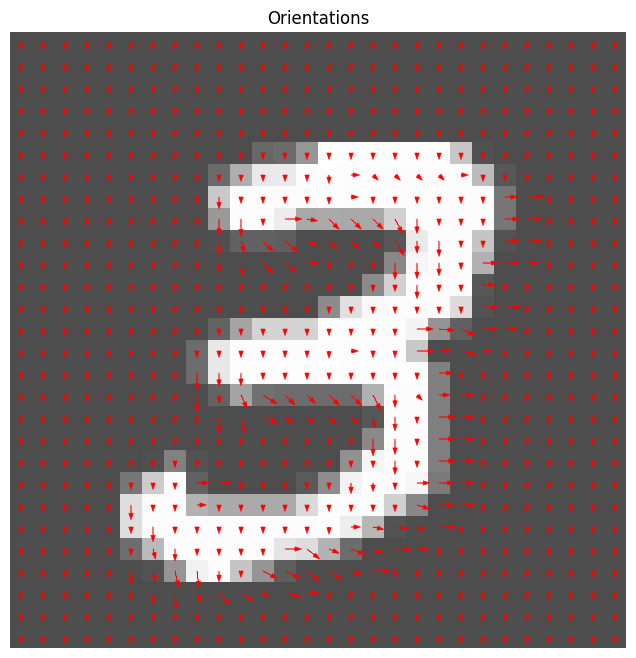

In [ ]:
img = x_raw[7]

mag, direc = Robert_cross_edge_detector(img)
# visualize_gradient_magnitude(mag)
visualize_gradients_within_pixels(img, mag, direc)